# Decision Tree Model

In [42]:
# decision tree model
import math
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


In [47]:
# Auxiliar functions

def entropy_func(c, n):
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    if c1== 0 or c2 == 0:  
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

def entropy_of_one_division(division): 
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

def get_entropy(y_predict, y_real):
    """
    Getting the whole entropy
    """
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

class OurDecisionTreeClassifier(object):
    """ Decision Tree model using numpy """

    def __init__(self, max_depth=5):
        """
        Model constructor
        Inputs:
        max_depth -> maximum depth of the classifier tree
        """
        self.depth = 0
        self.max_depth = max_depth

    def get_params(self, deep=True):
        """
        Get the model hyperparameters
        """
        return {"max_depth": self.max_depth}
    
    def set_params(self, **params):
        """
        Set de model hyperparameters
        """
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, x, y, par_node={}, depth=0):
        """
        Training function that generates the tree progressively by using the
        entropy
        """
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'col': features[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y))}
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    #all features versus values, get best
    def find_best_split_of_all(self, x, y):
        """
        Get the best values that can split the dataset with 
        the lower entropoy possible
        """
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x.T):
            entropy, cur_cutoff = self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy
    
    def find_best_split(self, col, y):
        """
        Calculate the entropy of only one feature
        """
        min_entropy = 10
        n = len(y)
        for value in set(col):
            y_predict = col < value #get which ones are less than
            my_entropy = get_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
                                           
    def predict(self, x):
        """
        Predict the category of a series of values
        """
        tree = self.trees
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        try:
            while cur_layer.get('cutoff'):
                if row[cur_layer['index_col']] < cur_layer['cutoff']:
                    cur_layer = cur_layer['left']
                else:
                    cur_layer = cur_layer['right']
            else:
                return cur_layer.get('val')
        except:
            return 0.0
    
    def score(self, X, y):
        """
        Score the values obtained
        """
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy
    
    # model metrics
        
    def accurancy(self, y_pred, y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
    
    def auc(self, y_pred,y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc
    
    def plot_roc(self, fpr, tpr, title):
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Especificity')
        plt.ylabel('Sensibility')
        plt.title(title)
        plt.show()

## Load Cancer dataset


In [53]:
# read first data set
df_2021_s1_grades = pd.read_csv('datasets/2021-s1.csv', sep=";")

# make sure that there are no null values that can affect the models
mask = df_2021_s1_grades.isnull()
#print(mask.sum())

df_2021_s1_grades = df_2021_s1_grades.drop('Tarea 2 Entrega 0.0%', axis=1)
df_2021_s1_grades = df_2021_s1_grades.drop('Proyecto Individual Viernes 0.0%', axis=1)
df_2021_s1_grades = df_2021_s1_grades.drop('Proyecto Individual Lunes 0.0%', axis=1)
df_2021_s1_grades = df_2021_s1_grades.drop('Exposición', axis=1)

# Arranging cols
col_Investi = df_2021_s1_grades.pop('Total: Investigación 5.0%')  # Cut col
df_2021_s1_grades.insert(14, 'Total: Investigación 5.0%', col_Investi)  # Insert col

# read second data set
df_2021_s2_grades = pd.read_csv('datasets/2021-s2.csv', sep=";")

# make sure that there are no null values that can affect the models
mask = df_2021_s2_grades.isnull()
#print(mask.sum())

df_2021_s2_grades = df_2021_s2_grades.drop('Examen 2 Práctico Ext 0.25%', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Proyecto Individual Entrega V 0.0%', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Proyecto Individual Entrega M 0.0%', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Entrega', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen 1', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen 2', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen 3', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen 4', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Total: Extra 2.0%', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Resumen', axis=1)
df_2021_s2_grades = df_2021_s2_grades.drop('Total: Extra 5 noviembre 1.0%', axis=1)

# read third data set
df_2022_s1_grades = pd.read_csv('datasets/2022-s1.csv', sep=";")

# make sure that there are no null values that can affect the models
mask = df_2022_s1_grades.isnull()
#print(mask.sum())

# delete students from robot project (only 6 in the whole data set)
df_2022_s1_grades = df_2022_s1_grades.drop([0, 4, 10, 20, 22, 26]) 

df_2022_s1_grades = df_2022_s1_grades.drop('Tarea 1 0.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Individual Entrega V 0.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Individual Entrega L 0.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Grupal 2 Anteproyecto 1.75%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Grup 2 Funcional Rob 11.38%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Proyecto Grupal 2 Docu Robot 4.37%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Entrega 0.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Evaluación 5.00%', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Evaluación', axis=1)
df_2022_s1_grades = df_2022_s1_grades.drop('Total: Puntaje extra 2%', axis=1)

# Arranging cols
col_Tarea2 = df_2022_s1_grades.pop('Tarea 2 3.75%')  # Cut col
df_2022_s1_grades.insert(5, 'Tarea 2 3.75%', col_Tarea2)  # Insert col

# read fourth data set
df_2022_s2_grades = pd.read_csv('datasets/2022-s2.csv', sep=";")

# make sure that there are no null values that can affect the models
mask = df_2022_s2_grades.isnull()
#print(mask.sum())

df_2022_s2_grades = df_2022_s2_grades.drop('Examen parcial 2 práctico repo 0.00%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Examen parcial 2 prác rep eval 0.00%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Tarea 2 0.00%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Proyecto Grupal 2 Anteproyecto 1.75%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Proyecto Grupal 1 Func Eval 13.12%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Proyecto Grupal 1 Docu Eval 4.38%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Entrega', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Charla 1 Simics 0.5%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Charla 2 Ronald 0.5%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Taller Simics 2%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Extra proyecto 1.75%', axis=1)
df_2022_s2_grades = df_2022_s2_grades.drop('Total: Extra 4.75%', axis=1)

# Merging four datasets frames into one frame

df_2021_s2_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)
df_2022_s1_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)
df_2022_s2_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)

df_arqui = pd.concat([df_2021_s1_grades, df_2021_s2_grades, df_2022_s1_grades, df_2022_s2_grades], axis=0, ignore_index=True)

df_arqui.replace(r'^\s*$', np.nan,regex=True, inplace=True)
df_arqui.fillna(0.0, inplace=True)
df_arqui = df_arqui.drop('Final', axis=1)


# Data preprocessing - outliner treatment
# eliminating data that is outside the normal values in each feature
features = ['Examen 1 15.0%', 
            'Examen 2 Práctico 5.0%', 
            'Examen 2 Teórico 10.0%', 
            'Total: Exámenes 30.0%', 
            'Tarea 1 3.75%', 
            'Tarea 2 Evaluación 3.75%', 
            'Total: Tareas 7.5%', 
            'Proyecto Individual Docu 3.75%', 
            'Proyecto Individual Funcional 11.25%', 
            'Proyecto Grupal 1 Funcional 13.12%',
            'Proyecto Grupal 1 Docu 4.38%',
            'Proyecto Grupal 2 Funcional 13.12%',
            'Proyecto Grupal 2 Docu 4.38%',
            'Total: Proyectos 50.0%',
            'Total: Investigación 5.0%',
            'Taller 1',
            'Taller 2',
            'Taller 3',
            'Taller 4',
            'Taller 5',
            'Total: Taller 7.5%']

l_limit_perc = 0.01
h_limit_perc = 0.99

df_arqui = df_arqui.astype(float)

for feature in features:
    low_limit = df_arqui[feature].quantile(l_limit_perc)
    high_limit = df_arqui[feature].quantile(h_limit_perc)
    df_arqui = df_arqui.loc[(df_arqui[feature] >= low_limit) & (df_arqui[feature] <= high_limit)]

# feature engineering
# normalization of the data
for feature in features:
    df_arqui[feature] = (df_arqui[feature]-df_arqui[feature].mean())/df_arqui[feature].std()

# change the value of the output to only two values
# 0 -> Student failed, less than 67.5 as final grade
# 1 -> Student passed, great or equal than 67.5 as final grade
df_arqui.loc[df_arqui['Total: '] <= 67.5, 'Total: '] = 0
df_arqui.loc[df_arqui['Total: '] > 67.5, 'Total: '] = 1

# Define training and test sets using stratify
X0 = df_arqui.loc[df_arqui['Total: '] == 0, features]
Y0 = df_arqui.loc[df_arqui['Total: '] == 0, 'Total: ']

X1 = df_arqui.loc[df_arqui['Total: '] == 1, features]
Y1 = df_arqui.loc[df_arqui['Total: '] == 1, 'Total: ']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.4, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=40)

X_train = pd.concat([X0_train, X1_train], axis= 0)
y_train = pd.concat([y0_train, y1_train], axis= 0)

df_arqui.head(5)

C:\Users\Juan Navarro\AppData\Local\Temp\ipykernel_26748\2537119905.py:83: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2021_s2_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)
C:\Users\Juan Navarro\AppData\Local\Temp\ipykernel_26748\2537119905.py:84: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2022_s1_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)
C:\Users\Juan Navarro\AppData\Local\Temp\ipykernel_26748\2537119905.py:85: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2022_s2_grades.set_axis(df_2021_s1_grades.columns, axis=1, inplace=True)


,Examen 1 15.0%,Examen 2 Práctico 5.0%,Examen 2 Teórico 10.0%,Total: Exámenes 30.0%,Tarea 1 3.75%,Tarea 2 Evaluación 3.75%,Total: Tareas 7.5%,Proyecto Individual Docu 3.75%,Proyecto Individual Funcional 11.25%,Proyecto Grupal 1 Funcional 13.12%,...,Proyecto Grupal 2 Docu 4.38%,Total: Proyectos 50.0%,Total: Investigación 5.0%,Taller 1,Taller 2,Taller 3,Taller 4,Taller 5,Total: Taller 7.5%,Total:
0,0.608534,-1.162069,-0.030399,-0.009979,0.823093,0.603086,0.835132,0.052219,1.151204,1.187786,...,0.188374,0.915790,0.544830,0.232150,0.852475,0.727088,-1.480341,1.074001,0.168250,1.0
1,-1.326258,-1.542372,-1.588984,-1.771099,-1.234709,-2.077296,-1.943578,-1.923581,-1.802788,-2.087235,...,-1.928273,-2.074044,-1.890585,-0.995520,-1.750624,-1.751650,-1.480341,-1.060796,-1.804104,0.0
2,0.432644,1.360705,0.236939,1.700783,1.472926,-2.077296,-0.364765,0.642393,1.151204,-0.613475,...,0.188374,0.353150,0.544830,0.845984,0.852475,0.727088,0.799638,-1.060796,0.284271,1.0
3,-1.925235,-1.542372,-1.588984,-2.035476,-1.234709,-2.077296,-1.943578,-1.923581,-1.802788,-2.087235,...,-1.928273,-2.074044,-1.890585,-2.223189,-1.750624,-1.751650,-1.480341,-1.060796,-2.036146,0.0
4,1.003098,-1.542372,-0.030399,0.072551,0.571283,0.603086,0.687776,0.642393,1.151204,1.187786,...,0.188374,0.968904,0.544830,0.845984,0.852475,-0.841953,0.799638,1.074001,0.496976,1.0


Best hyperparameters:  {'max_depth': 5}
    Amount of tests          Model  Accurancy  Precision  Recall       Auc
0                 1      Our model   1.000000   1.000000     1.0  1.000000
1                 1  Sklearn model   1.000000   1.000000     1.0  1.000000
2                 3      Our model   1.000000   1.000000     1.0  1.000000
3                 3  Sklearn model   1.000000   1.000000     1.0  1.000000
4                 6      Our model   1.000000   1.000000     1.0  1.000000
5                 6  Sklearn model   1.000000   1.000000     1.0  1.000000
6                 9      Our model   1.000000   1.000000     1.0  1.000000
7                 9  Sklearn model   0.944444   0.900000     1.0  0.944444
8                11      Our model   1.000000   1.000000     1.0  1.000000
9                11  Sklearn model   0.954545   0.916667     1.0  0.954545
10               13      Our model   1.000000   1.000000     1.0  1.000000
11               13  Sklearn model   0.961538   0.928571    

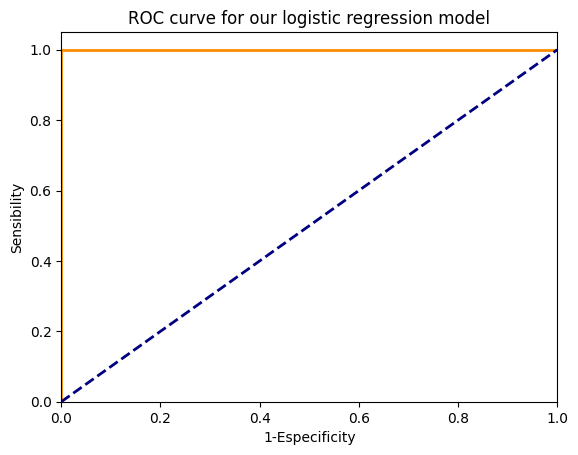

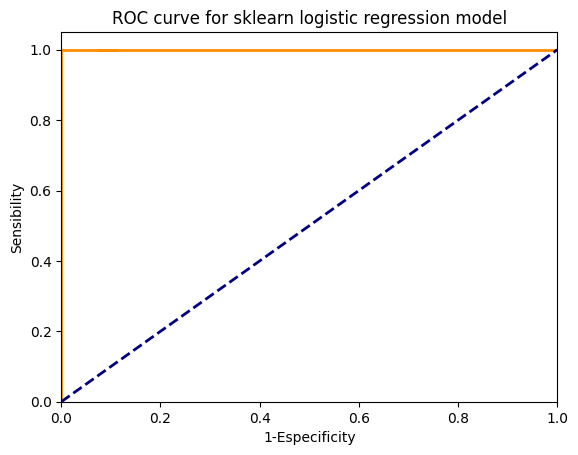

In [54]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
model = OurDecisionTreeClassifier()
param_grid = {'max_depth': [5, 6, 7]}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train.values, y_train.values)
print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurDecisionTreeClassifier(max_depth=7)
model.fit(x=X_train.values, y=y_train.values)

# Instantiate sklearn logistic regression model
model_sklearn = DecisionTreeClassifier()


model_sklearn.fit(X_train, y_train.astype('int'))

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i.values.astype(int))
    y_tests['sklearn_model'].append(y_test_i.values.astype(int))

    # predict classes for test set
    y_pred_i = model.predict(X_test_i.values)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))


# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

    

# display test metric results
title_row = ['Amount of tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Our model', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn model', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
model.plot_roc(fpr_model, tpr_model, 'ROC curve for our logistic regression model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn logistic regression model')